<a href="https://colab.research.google.com/github/dindararas/Data-Science-Portfolio/blob/main/Time%20Series%20Prediction/Air_Temperature_Time_Series_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TIME SERIES PREDICTION**

Time series prediction is the task of building a model fitted to historical data with the goal of forecasting future values. In this project, I will establish and evaluate deep learning methods (LSTM and CNN) for predicting **Monthly Air Temperature in Jakarta**. The prediction of air temperature is an important task since it affects crop production and other life aspects.

## **1. IMPORTING LIBRARIES**

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 21.0 MB/s 
     |████████████████████████████████| 1.6 MB 58.4 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Activation, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D, Lambda, Input
from tensorflow.keras.optimizers import Adam
import keras_tuner 
from keras_tuner import BayesianOptimization
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## **2. LOADING DATASET**

In [ ]:
cities = pd.read_csv('/content/GlobalLandTemperaturesByMajorCity.csv')

# Focus on Jakarta
city = cities['City'] == 'Jakarta'
jkt = cities.loc[city, ['dt', 'AverageTemperature']]
jkt.columns = ['Date', 'Temp']

# Set 'Date' as an index
jkt['Date'] = pd.to_datetime(jkt['Date'], format = '%Y-%m-%d')
jkt.set_index('Date', inplace = True)

# Round decimals
jkt = jkt.round(decimals = 2)

# Focus on the temperature from 1990 until the end of data
jkt = jkt.loc['1985-01-01' :]
jkt.head()

,Temp
Date,
1985-01-01,26.15
1985-02-01,27.23
1985-03-01,27.22
1985-04-01,27.36
1985-05-01,27.65


In [ ]:
# Dataframe shape
print(f'Dataframe has : {jkt.shape[0]} rows and {jkt.shape[1]} columns')

Dataframe has : 345 rows and 1 columns


## **2. EXPLORATORY DATA ANALYSIS**

### **Temperature Changes Yearly**

In [ ]:
# Plot the temperature changes
def plot_temp(df, y = str) :
  fig = px.line(df, x = df.index, y = y, title = 'Temperature Changes in Jakarta' )
  fig.show()

In [ ]:
plot_temp(jkt, 'Temp')

### **Temperature Changes Monthly**

In [ ]:
# Pivot table
df = jkt.copy()
df['Month'] = df.index.month
df['Year'] = df.index.year
monthly = pd.pivot_table(df, values = 'Temp', index = 'Month', columns = 'Year', aggfunc = 'mean').mean(axis=1).to_frame()
monthly.columns = ['Temp']
monthly = monthly.round(decimals = 2)

# Visualization
plot_temp(monthly, 'Temp')

It can be seen that the highest temperature in Jakarta was in May throughout years. Furthermore, temperature increased from January to May and then decreased until December. It makes sense because May is dry season in Indonesia.

### **Check Missing Values**

In [ ]:
# Check NaN values
print(f'NaN value of dataframe : {jkt.isna().sum()}')

# Data interpolation
jkt = jkt.interpolate()

NaN value of dataframe : Temp    1
dtype: int64


There is one missing value in this dataset. I applied interpolation method to fill the missing value.

### **Check Outliers**

In [ ]:
# Using Isolation forest to detect outliers
outliers = jkt.copy()
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.003), max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(outliers[['Temp']])
outliers['scores']=clf.decision_function(outliers[['Temp']])
outliers['anomaly']=clf.predict(outliers[['Temp']])
outliers.loc[outliers['anomaly'] == 1,'anomaly'] = 0
outliers.loc[outliers['anomaly'] == -1,'anomaly'] = 1
outliers.head()

,Temp,scores,anomaly
Date,,,
1985-01-01,26.15,0.099822,0
1985-02-01,27.23,0.283081,0
1985-03-01,27.22,0.286284,0
1985-04-01,27.36,0.289144,0
1985-05-01,27.65,0.275573,0


In [ ]:
def plot_anomaly(df,metric_name):
  df.reset_index(inplace = True)
  Date = df.Date
  #identify the anomaly points and create a array of its values for plot
  bool_array = (abs(df['anomaly']) > 0)
  actuals = df['Temp'][-len(bool_array):]
  anomaly_points = bool_array * actuals
  anomaly_points[anomaly_points == 0] = np.nan

  # Table which includes Date,Actuals,Change occured from previous point
  table = go.Table(domain=dict(x=[0, 1], y=[0, 0.3]),columnwidth=[1, 2],
                   header=dict(height=20, values=[['<b>Date</b>'], ['<b>Actual Values </b>'],],
                               font=dict(color=['rgb(45, 45, 45)'] * 5, size=14)), 
                   cells=dict(values=[df.round(3)[k].tolist() for k in ['Date', 'Temp']], line=dict(color='#506784'),
                              align=['center'] * 5,font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),suffix=[None] + [''] + [''] + ['%'] + [''],
                              height=27))
  Actuals = go.Scatter(name='Actuals', x=Date, y=df['Temp'], xaxis='x1', yaxis='y1', mode='lines', marker=dict(size=12, line=dict(width=1),
                                                                                                              color="blue"))
    #Highlight the anomaly points
  anomalies_map = go.Scatter(name='Outlier',showlegend=True, x=Date, y=anomaly_points, mode='markers',
                             xaxis='x1', yaxis='y1',marker=dict(color="red",size=11, line=dict(color="red", width=2)))
  axis = dict(showline=True, zeroline=False,showgrid=True, mirror=True,ticklen=4, gridcolor='#ffffff',tickfont=dict(size=10))
  layout = dict(width=1000,height=865,autosize=False, title=metric_name, margin=dict(t=75),showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)), 
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
  fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
  fig.show()
plot_anomaly(outliers,'Outliers Detection')

Two outliers are detected in this dataset. The extreme temperature was 25.92 and 28.76 degrees Celcius that happened in December 1988 and May 1998, respectively. Because these outliers might be useful information, I will not remove these datapoints.

## **3. DATA PREPROCESSING**

### **Train-Test Split**

In [ ]:
# 70% of data is used for training and 30% of data for testing
train = jkt.iloc[0: int(len(jkt)*0.7), :]
test = jkt.iloc[int(len(jkt)*0.7) :, :]

# Plot train-test split
trace1  = go.Scatter(mode='lines', x = train.index, y = train['Temp'], name='Training', marker_color='crimson')
trace2 = go.Scatter(mode='lines', x = test.index, y = test['Temp'], name='Testing', marker_color='blue')

data = [trace1, trace2]
layout = go.Layout(title_text='Train-test Split')
fig = go.Figure(data=data, layout=layout)
fig.show()

### **Feature Scaling**


In [ ]:
# Minmax Scaler
sc = MinMaxScaler(feature_range = (0,1))

train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

### **Data Shape Conversion**

Before building a model, LSTM and CNN expects the input data to be of **3D shape (number of samples, timesteps, number of features)**. For this project, I choose timesteps = 6.

In [ ]:
def data_conv(data, timesteps):
  x, y = [], []
  for i in range(timesteps, data.shape[0]):
    x.append(data[i-timesteps:i,0])
    y.append(data[i,0])

  # Convert to the format of #number of samples, #timesteps, #features
  x = np.array(x)
  x = x.reshape(x.shape[0], x.shape[1], 1)
  y = np.array(y)
    
  return x,y

In [ ]:
timesteps = 6 # use data from previous 6 months to predict 1 future month
# Training Data
train_x, train_y = data_conv(train_sc, timesteps)

# Testing Data
test_x, test_y = data_conv(test_sc, timesteps)

In [ ]:
# Training Data
print(f'Train_x shape : {train_x.shape}')
print(f'Train_y shape : {train_y.shape}')

# Testing Data
print(f'Test_x shape : {test_x.shape}')
print(f'Test_y shape : {test_y.shape}')

Train_x shape : (235, 6, 1)
Train_y shape : (235,)
Test_x shape : (98, 6, 1)
Test_y shape : (98,)


## **4. HYPERPARAMETER TUNING**

In [ ]:
# Function for building the hyperparameter tuning LSTM 
def build_lstm(hp):
  activation = hp.Choice('activation', ['relu', 'tanh',  'selu','elu'])
  num_rnn_layers = hp.Int('num_rnn_layers', min_value=1, max_value=64)
  dropout_rate = hp.Float('dropout_rate', min_value = 0.2, max_value = 0.9)
  num_units = hp.Int('num_units', min_value=1, max_value=100)
      
  model = Sequential()
  # Input Layer 
  model.add(LSTM(units=num_units, activation=activation,input_shape=(timesteps, 1), return_sequences = True))
    
  # Tune the number of hidden layers
  # Hidden Layers
  for i in range(num_rnn_layers) :
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=num_units, activation = activation, return_sequences = True))
        
  model.add(LSTM(units=num_units, activation = activation, return_sequences = False))
  # Output Layes
  model.add(Dense(1, activation = activation))
  
  # Compile the model
  model.compile(loss='mean_squared_error', optimizer='Adam', metrics = ['mse', 'mae'])                                       
  return model

In [ ]:
def build_cnn(hp):
  # Hyperparameter Tuning for Conv1D
  kernel = hp.Int('kernel', min_value = 1, max_value = 3)
  filter = hp.Choice('filter', [32, 64,128]) # filter is used for data extraction
  unit = hp.Int('unit', min_value = 10, max_value = 100)
  dropout = hp.Float('dropout', min_value = 0.2, max_value = 0.9)
  activation_cnn = hp.Choice('activation_cnn', ['relu', 'sigmoid', 'softmax', 'tanh'])
  activation_dense = hp.Choice('activation_dense',['relu', 'tanh',  'selu','elu'])

  model = Sequential()
  model.add(Conv1D(filters = filter, kernel_size= kernel, kernel_initializer = 'he_normal', activation = activation_cnn, input_shape = (timesteps, 1)))
  model.add(MaxPooling1D(pool_size = 1))
  model.add(Flatten()) 
  model.add(Dropout(dropout))
  model.add(Dense(units = unit, activation = activation_dense))
  model.add(Dropout(dropout))
  # Output Layer
  model.add(Dense(1, activation = 'relu'))
  
  # Compile the model
  model.compile(loss='mean_squared_error', optimizer='Adam', metrics = ['mse', 'mae'])                                       
  return model

In [ ]:
# Function to get best model and best hyperparameter of LSTM 
def best_model_lstm(tuner, df1, df2, df3, df4,  n_epochs=100) :
  tuner.search(df1, df2, epochs = n_epochs, validation_data = (df3, df4), verbose =1)
  best_model = tuner.get_best_models(num_models=1)
  model = best_model[0]
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  unit = best_hps.get('num_units')
  layer = best_hps.get('num_rnn_layers')
  activation = best_hps.get('activation')
  dropout = best_hps.get('dropout_rate')
  return model, unit, layer, activation, dropout

# Function to get best model and best hyperparameters of CNN1D
def best_model_cnn(tuner, df1, df2, df3, df4,  n_epochs=100) :
  tuner.search(df1, df2, epochs = n_epochs, validation_data = (df3, df4), verbose =1)
  best_model = tuner.get_best_models(num_models=1)
  model = best_model[0]
  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  unit = best_hps.get('unit')
  kernel = best_hps.get('kernel')
  activation_cnn = best_hps.get('activation_cnn')
  activation_dense = best_hps.get('activation_dense')
  dropout = best_hps.get('dropout')
  filter = best_hps.get('filter')
  return model, unit, kernel, activation_cnn, activation_dense, dropout, filter

In [ ]:
# Function to display the best hyperparameters of LSTM and BiLSTM
def best_hps_lstm(unit, layer, activation, dropout) :

  output = print(f"""The hyperparameter search is complete. The optimal number of layer is {layer}, 
  the optimal number of units is {unit},
  the best activation is {activation},
  the best dropout is {dropout}""")
  
  return output

# Function to display the best hyperparameters of CNN
def best_hps_cnn(unit, kernel, activation_cnn, activation_dense, dropout, filter) :

  output = print(f"""The hyperparameter search is complete. The optimal number of filter is {filter}, , 
  the optimal kernel size is {kernel},
  the optimal number of units is {unit},
  the best activation for CNN is {activation_cnn},
  the best activation for dense is {activation_dense},
  the best dropout is {dropout}""")
  
  return output

In [ ]:
def make_pred(model, df1, df2, df3, df4, epochs=100, batch_size=64) :
  # df1 = train_x
  # df2 = train_y
  # df3 = test_x
  # df4 = test_y
  history = model.fit(df1, df2, epochs = epochs, batch_size = batch_size, verbose = 1, validation_data = (df3, df4) )

  # make predictions
  best_pred_train= model.predict(df1)
  best_pred_test = model.predict(df3)

   # invert predictions
  best_pred_train_inv = sc.inverse_transform(best_pred_train)
  df2_inv = sc.inverse_transform([df2])
  best_pred_test_inv = sc.inverse_transform(best_pred_test)
  df4_inv = sc.inverse_transform([df4])

  return best_pred_train_inv, best_pred_test_inv, df2_inv, df4_inv, history

In [ ]:
# Function to evaluate the model and also display the RMSE and MAE values
def model_evaluation(best_pred_train_inv, best_pred_test_inv, df2_inv, df4_inv) :
  rmse_train = sqrt(mean_squared_error(df2_inv[0], best_pred_train_inv[:,0]))
  rmse_test = sqrt(mean_squared_error(df4_inv[0], best_pred_test_inv[:,0]))
  mae_train = mean_absolute_error(df2_inv[0], best_pred_train_inv[:,0])
  mae_test =  mean_absolute_error(df4_inv[0], best_pred_test_inv[:,0])

  return rmse_train, rmse_test, mae_train, mae_test

In [ ]:
def pred_plot(df, best_pred1, best_pred2) :
  plt.figure(figsize=(12,6))
  plt.plot( df[0][:80], 'k', label="Actual")
  plt.plot(best_pred1[:,0][:80], 'b', label="CNN")
  plt.plot(best_pred2[:,0][:80], 'r', label = 'LSTM')
  # plt.tick_params(left=False, labelleft=True) #remove ticks
  plt.tight_layout()
  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.ylabel('Air Temperature', size=15)
  plt.xlabel('Timestep', size=15)
  plt.legend(fontsize=15)
  plt.show()

## **5. MODEL BUILDING**

### **LSTM**

In [ ]:
tuner_lstm = BayesianOptimization(build_lstm, objective = 'val_loss', max_trials = 10, directory = 'tuner_lstm', project_name = 'bayesian_opt')

In [ ]:
model_lstm, unit_lstm, layer_lstm, activation_lstm, dropout_lstm = best_model_lstm(tuner_lstm, train_x, train_y, test_x, test_y)

Trial 10 Complete [00h 00m 28s]
val_loss: 0.02860938012599945

Best val_loss So Far: 0.027750518172979355
Total elapsed time: 00h 29m 43s


In [ ]:
best_hps_lstm(unit_lstm, layer_lstm, activation_lstm, dropout_lstm)

The hyperparameter search is complete. The optimal number of layer is 1, 
  the optimal number of units is 100,
  the best activation is relu,
  the best dropout is 0.8999999999999999


In [ ]:
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 6, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 100)            80400     
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
pred_train_lstm, pred_test_lstm, ntrain_y, ntest_y, history_lstm = make_pred(model_lstm, train_x, train_y, test_x, test_y)

Epoch 1/100
4/4 [==============================] - 4s 204ms/step - loss: 0.0310 - mse: 0.0310 - mae: 0.1445 - val_loss: 0.0307 - val_mse: 0.0307 - val_mae: 0.1350
Epoch 2/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0311 - mse: 0.0311 - mae: 0.1408 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1408
Epoch 3/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0312 - mse: 0.0312 - mae: 0.1415 - val_loss: 0.0305 - val_mse: 0.0305 - val_mae: 0.1348
Epoch 4/100
4/4 [==============================] - 0s 37ms/step - loss: 0.0308 - mse: 0.0308 - mae: 0.1410 - val_loss: 0.0298 - val_mse: 0.0298 - val_mae: 0.1330
Epoch 5/100
4/4 [==============================] - 0s 34ms/step - loss: 0.0309 - mse: 0.0309 - mae: 0.1429 - val_loss: 0.0295 - val_mse: 0.0295 - val_mae: 0.1325
Epoch 6/100
4/4 [==============================] - 0s 35ms/step - loss: 0.0306 - mse: 0.0306 - mae: 0.1434 - val_loss: 0.0330 - val_mse: 0.0330 - val_mae: 0.1415
Epoch 7/100
4/4 [==========

In [ ]:
rmse_trainlstm, rmse_testlstm, mae_trainlstm, mae_testlstm = model_evaluation(pred_train_lstm, pred_test_lstm, ntrain_y, ntest_y)
print(f"""RMSE score train: {rmse_trainlstm}
  \nRMSE score test: {rmse_testlstm}
  '\nMAE score train : {mae_trainlstm}
  '\nMAE score test :  {mae_testlstm}""")

RMSE score train: 0.4930890906891181
  
RMSE score test: 0.5146548834372238
  '
MAE score train : 0.3924336031649975
  '
MAE score test :  0.4147162184423326


### **CNN**

In [ ]:
tuner_cnn = BayesianOptimization(build_cnn, objective = 'val_loss', max_trials = 10, directory = 'tuner_cnn', project_name = 'bayesian_opt')

In [ ]:
model_cnn, unit_cnn, kernel_cnn, activation_cnn, activation_dense, dropout_cnn, filter_cnn = best_model_cnn(tuner_cnn, train_x, train_y, test_x, test_y)

Trial 10 Complete [00h 00m 09s]
val_loss: 0.016166552901268005

Best val_loss So Far: 0.015661999583244324
Total elapsed time: 00h 01m 49s


In [ ]:
best_hps_cnn(unit_cnn, kernel_cnn, activation_cnn, activation_dense, dropout_cnn, filter_cnn)

The hyperparameter search is complete. The optimal number of filter is 128, , 
  the optimal kernel size is 1,
  the optimal number of units is 10,
  the best activation for CNN is tanh,
  the best activation for dense is relu,
  the best dropout is 0.2


In [ ]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 128)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 6, 128)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 10)                7690      
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                        

In [ ]:
pred_train_cnn, pred_test_cnn, ntrain_y, ntest_y, history1_cnn = make_pred(model_cnn, train_x, train_y, test_x, test_y)

Epoch 1/100
4/4 [==============================] - 1s 68ms/step - loss: 0.0247 - mse: 0.0247 - mae: 0.1248 - val_loss: 0.0157 - val_mse: 0.0157 - val_mae: 0.1021
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 0.0243 - mse: 0.0243 - mae: 0.1212 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.1052
Epoch 3/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0231 - mse: 0.0231 - mae: 0.1222 - val_loss: 0.0183 - val_mse: 0.0183 - val_mae: 0.1098
Epoch 4/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0223 - mse: 0.0223 - mae: 0.1204 - val_loss: 0.0177 - val_mse: 0.0177 - val_mae: 0.1081
Epoch 5/100
4/4 [==============================] - 0s 15ms/step - loss: 0.0228 - mse: 0.0228 - mae: 0.1193 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.1057
Epoch 6/100
4/4 [==============================] - 0s 14ms/step - loss: 0.0205 - mse: 0.0205 - mae: 0.1143 - val_loss: 0.0166 - val_mse: 0.0166 - val_mae: 0.1046
Epoch 7/100
4/4 [===========

In [ ]:
rmse_traincnn, rmse_testcnn, mae_traincnn, mae_testcnn = model_evaluation(pred_train_cnn, pred_test_cnn, ntrain_y, ntest_y)
print(f"""RMSE score train: {rmse_traincnn}
  \nRMSE score test: {rmse_testcnn}
  '\nMAE score train : {mae_traincnn}
  '\nMAE score test :  {mae_testcnn}""")

RMSE score train: 0.37088779720734555
  
RMSE score test: 0.3698407014006863
  '
MAE score train : 0.2969153150193233
  '
MAE score test :  0.3039625237912545


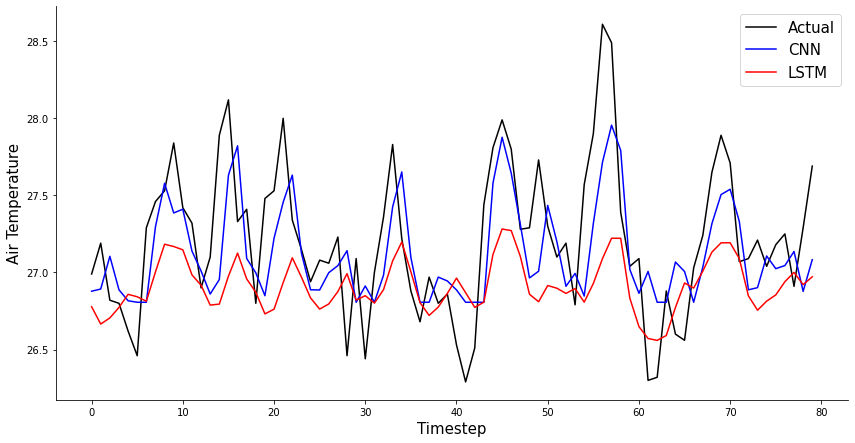

In [ ]:
pred_plot(ntest_y,  pred_test_cnn, pred_test_lstm)

## **6. MODEL COMPARISON**

In [ ]:
model_comparison = pd.DataFrame(columns = ['Model', 'RMSE Training', 'RMSE Testing', 'MAE Training', 'MAE Testing'])
model_comparison = model_comparison.append({'Model' : 'LSTM', 'RMSE Training' : rmse_trainlstm, 'RMSE Testing' : rmse_testlstm, 
                                            'MAE Training' : mae_trainlstm, 'MAE Testing' : mae_testlstm }, ignore_index = True)
model_comparison = model_comparison.append({'Model' : 'CNN', 'RMSE Training' : rmse_traincnn, 'RMSE Testing' : rmse_testcnn, 
                                            'MAE Training' : mae_traincnn, 'MAE Testing' : mae_testcnn }, ignore_index = True)

model_comparison = model_comparison.round(decimals = 2)
model_comparison

,Model,RMSE Training,RMSE Testing,MAE Training,MAE Testing
0,LSTM,0.49,0.51,0.39,0.41
1,CNN,0.37,0.37,0.30,0.30


It can be seen that CNN outperforms LSTM, so I will predict the next month by building the tuned CNN

## **7. PREDICTION**

In [ ]:
pred_list = test_sc[-timesteps:]

# Data shape conversion
x = pred_list.reshape((1, timesteps, 1))
out = model_cnn.predict(x)[0][0]


pred_list = np.append(pred_list, out)
pred_list = pred_list.reshape(-1,1)
pred_list_inv = sc.inverse_transform(pred_list)

In [ ]:
# Date dataframe
date = ['2013-04-01', '2013-05-01','2013-06-01', '2013-07-01', '2013-08-01', '2013-09-01', '2013-10-01']
date = pd.DataFrame(date)
date.columns = ['Date']

pred = pd.DataFrame(pred_list_inv)
pred.columns = ['Temp']

pred_list = pd.concat([date, pred], axis=1)
pred_list['Date'] = pd.to_datetime(pred_list['Date'], format = '%Y-%m-%d')


# Plot train-test split
trace1  = go.Scatter(mode='lines', x = pred_list.Date.values[0:-1], y = pred_list.Temp.values[0:-1], name = 'Actual' , marker_color='blue')
trace2 = go.Scatter(mode='lines', x = pred_list.Date.values[-2:], y = pred_list.Temp.values[-2:], name = 'Prediction', marker_color='crimson')

data = [trace1, trace2]
layout = go.Layout(title_text='Prediction')
fig = go.Figure(data=data, layout=layout)
fig.show()

Air temperature in October 2013 will be **26.93 degrees Celcius**